In [6]:
using ModelingToolkit, MethodOfLines, OrdinaryDiffEq, DomainSets

In [14]:
using Random

function initial_condition_kdv(x, η=6.0, P=20.0)
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (Float64 or AbstractArray) : A single point or array in the spatial domain. 
        key (Random.AbstractRNG): The random key for generating random numbers.
        η (Float64, optional): The coefficient for the KdV equation. Default is 6.
        P (Float64, optional): The period of the spatial domain. Default is 20.
    Returns:
        AbstractArray: The initial condition for the KdV equation.
    """
    
    c1, c2 = 0.7, 1.3
    d1, d2 = 0.3, 0.7
    
    u0 = (-6.0 / -η) * 2 * c1^2 * sech(c1 * ((x + P/2 - P*d1) % P - P/2))^2
    u0 += (-6.0 / -η) * 2 * c2^2 * sech(c2 * ((x + P/2 - P*d2) % P - P/2))^2
    return u0
end


initial_condition_kdv (generic function with 4 methods)

In [88]:
@parameters x t
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

x_min = t_min = 0.0
x_max = 20.0
t_max = 5.
η = 6.
γ = 1.

u0(x,t) = initial_condition_kdv(x)

eq = [Dt(u(x,t)) ~ -γ*Dx(0.5*η*u(x,t)^2 + γ^2 * Dxx(u(x,t))),]

domains = [x ∈ Interval(x_min, x_max), t ∈ Interval(t_min, t_max)]

# Periodic BCs
bcs = [u(x,0) ~ u0(x,0),
       u(x_min,t) ~ u(x_max,t)] 

@named pdesys = PDESystem(eq,bcs,domains,[x,t],[u(x,t),])

PDESystem
Equations: Equation[Differential(t)(u(x, t)) ~ -Differential(x)(Differential(x)(Differential(x)(u(x, t))) + 3.0(u(x, t)^2))]
Boundary Conditions: Equation[u(x, 0) ~ 3.3800000000000003(sech(1.3(-10.0 + rem(-4.0 + x, 20.0)))^2) + 0.9799999999999999(sech(0.7(-10.0 + rem(4.0 + x, 20.0)))^2), u(0.0, t) ~ u(20.0, t)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 20.0), Symbolics.VarDomainPairing(t, 0.0 .. 5.0)]
Dependent Variables: Num[u(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [98]:
N = 100
M = 100
dt = t_max/N

order = 2 # This may be increased to improve accuracy of some schemes

# Integers for x and y are interpreted as number of points. Use a Float to directtly specify stepsizes dx and dy.
discretization = MOLFiniteDifference([x=>M,t=>dt], approx_order=order)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Float64}(t => 0.05, x => 100.0), nothing, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Any[], Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}())

In [99]:
# Convert the PDE problem into an ODE problem
println("Discretization:")
@time prob = discretize(pdesys,discretization)

Discretization:


┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines C:\Users\eirik\.julia\packages\MethodOfLines\EiZyI\src\system_parsing\pde_system_transformation.jl:43
┌ Warning: dx for x does not divide domain exactly, adding grid point at x = 20.0).
└ @ MethodOfLines C:\Users\eirik\.julia\packages\MethodOfLines\EiZyI\src\discretization\discretize_vars.jl:177


BoundsError: BoundsError: attempt to access 1-element Vector{Float64} at index [1:3]

In [91]:
using IRKGaussLegendre

In [96]:
println("Solve:")
@time sol = solve(prob, IRKGL16(), dt=0.001)

Solve:
  0.003261 seconds (2.06 k allocations: 227.500 KiB)
PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(x, t): (100, 14) sized solution
  Domain:
    t ∈ (0.0, 5.0) with 14 non-uniform points. average step size 0.38461538461538464
    x ∈ (0.0, 20.0) with 100 points, step size 0.20202020202020202
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t} u\left( x, t \right) + \frac{\mathrm{d}}{\mathrm{d}x} \left( \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( x, t \right) + 3 \left( u\left( x, t \right) \right)^{2} \right) &= 0
\end{align}
"

L"\begin{align}
u\left( x, 0 \right) &= 3.38 \mathrm{sech}^{2}\left( 1.3 \left( -10 + rem\left( -4 + x, 20 \right) \right) \right) + 0.98 \mathrm{sech}^{2}\left( 0.7 \left( -10 + rem\left( 4 + x, 20 \right) \right) \right) \\
u\left( 0, t \right) &= u\left( 20, t \right)
\end{align}
"

In [93]:
using Plots

In [94]:
solu = sol[u(x, t)]

100×10 Matrix{Float64}:
 0.000883353  0.000883353  0.000883353  …  0.000883353  0.000883353
 0.00116892   0.00116892   0.00116892      0.00116892   0.00116892
 0.00155071   0.00155071   0.00155071      0.00155071   0.00155071
 0.00205707   0.00205707   0.00205707      0.00205707   0.00205707
 0.00272854   0.00272854   0.00272854      0.00272854   0.00272854
 0.00361879   0.00361879   0.00361879   …  0.00361879   0.00361879
 0.00479879   0.00479879   0.00479879      0.00479879   0.00479879
 0.00636231   0.00636231   0.00636231      0.00636231   0.00636231
 0.00843303   0.00843303   0.00843303      0.00843303   0.00843303
 0.0111738    0.0111738    0.0111738       0.0111738    0.0111738
 ⋮                                      ⋱               
 0.000243403  0.000243403  0.000243403     0.000243403  0.000243403
 0.000211419  0.000211419  0.000211419     0.000211419  0.000211419
 0.000214555  0.000214555  0.000214555     0.000214555  0.000214555
 0.000245667  0.000245667  0.000245667     0.

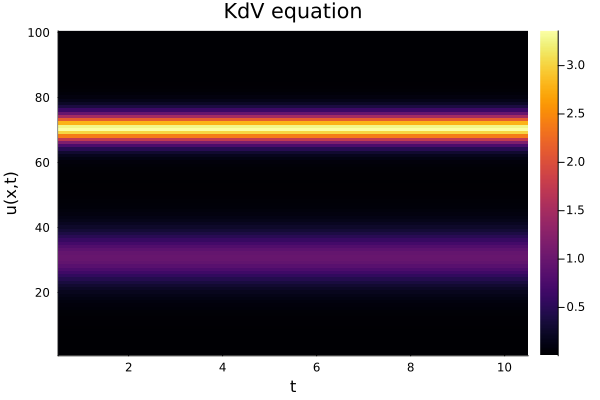

In [95]:
heatmap(solu, xlabel="t", ylabel="u(x,t)", title="KdV equation", label="u(x,t)", lw=2)